In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random

In [ ]:
import albumentations
import albumentations.pytorch

In [ ]:
albumentations.__version__

'0.1.12'

In [ ]:
!pip3 install quickdraw

In [ ]:
from quickdraw import QuickDrawData, QuickDrawDataGroup

In [ ]:
seed = 111

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [ ]:
num_img_per_class = 3000

qd = QuickDrawData(max_drawings=num_img_per_class)

class_list = ['apple', 
              'wine bottle', 
              'spoon', 
              'rainbow', 
              'panda', 
              'hospital', 
              'scissors', 
              'toothpaste', 
              'baseball', 
              'hourglass']

class_dict = {'apple' : 0, 
              'wine bottle' : 1, 
              'spoon' : 2, 
              'rainbow' : 3, 
              'panda': 4, 
              'hospital' : 5, 
              'scissors' : 6, 
              'toothpaste' : 7, 
              'baseball' : 8, 
              'hourglass' : 9}

In [ ]:
qd.load_drawings(class_list)

downloading apple from https://storage.googleapis.com/quickdraw_dataset/full/binary/apple.bin
download complete
loading apple drawings
load complete
downloading wine bottle from https://storage.googleapis.com/quickdraw_dataset/full/binary/wine bottle.bin
download complete
loading wine bottle drawings
load complete
downloading spoon from https://storage.googleapis.com/quickdraw_dataset/full/binary/spoon.bin
download complete
loading spoon drawings
load complete
downloading rainbow from https://storage.googleapis.com/quickdraw_dataset/full/binary/rainbow.bin
download complete
loading rainbow drawings
load complete
downloading panda from https://storage.googleapis.com/quickdraw_dataset/full/binary/panda.bin
download complete
loading panda drawings
load complete
downloading hospital from https://storage.googleapis.com/quickdraw_dataset/full/binary/hospital.bin
download complete
loading hospital drawings
load complete
downloading scissors from https://storage.googleapis.com/quickdraw_datase

In [ ]:
train_data = []
val_data = []

train_label = []
val_label = []

for class_name in class_list:
    qdgroup = QuickDrawDataGroup(class_name,
                                 max_drawings=num_img_per_class)
    
    for i, img in enumerate(qdgroup.drawings):
        if i<int(0.9*num_img_per_class):
            train_data.append(img.get_image())
            train_label.append(class_dict[class_name])
        else:
            val_data.append(img.get_image())
            val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [ ]:
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img = self.data[idx]
        
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# torchvision Transform

In [ ]:
transform = transforms.Compose([
    transforms.RandomAdjustSharpness(sharpness_factor=0),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomCrop(230), # 255 -> 230
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
    # ImageNet의 mean과 std로, 통상적으로 normalize 수행할 때 사용함
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

In [ ]:
image = next(iter(train_data))
print(type(image))

tensor = transforms.ToTensor()(image)
print(tensor.shape)

<class 'PIL.Image.Image'>
torch.Size([3, 255, 255])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


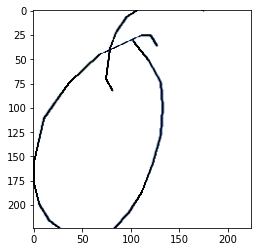

In [ ]:
image = transform(image)
plt.imshow(image.permute(1, 2, 0))

# albumentations Transform

In [ ]:
albumentations_transform = albumentations.Compose([
    albumentations.RandomCrop(230,230),
    albumentations.Resize(224, 224), 
    albumentations.HorizontalFlip(),
    albumentations.Blur(p=1.0),
    albumentations.pytorch.transforms.ToTensor()
])

In [ ]:
image = next(iter(train_data))
print(type(image))

# tensor = albumentations.pytorch.transforms.ToTensor()(image=np.array(image))
# print(tensor.shape)

<class 'PIL.Image.Image'>


In [ ]:
# image = albumentations_transform(image=np.array(image))
# plt.imshow(image)

# Dataset, DataLoader

In [ ]:
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform_val)

qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=64, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=64, shuffle=True)

# Visualizing augmented images
- Channel order:
  - cv2: BGR
  - torch: RGB
- Dimension:
  - cv2: (height, width, channel)
  - torch conv2d layer: (batch_size, channel, height, width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


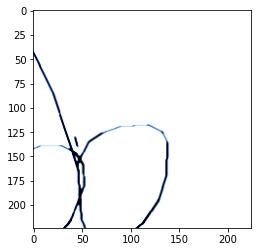

torch.Size([3, 224, 224])
tensor(6)


In [ ]:
img, label = next(iter(qd_train_dataloader))

plt.imshow(img[0].permute(1, 2, 0)) # torch.permute: dimension swapping
plt.show()
print(img[0].shape)
print(label[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


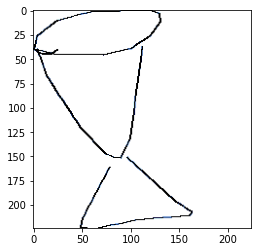

torch.Size([3, 224, 224])
tensor(9)


In [ ]:
val_img, val_label = next(iter(qd_val_dataloader))

plt.imshow(val_img[0].permute(1, 2, 0))
plt.show()
print(val_img[0].shape)
print(val_label[0])

# Training VGG-11 with augmented images

In [ ]:
from torchvision.models import vgg11

pretrained=True

model = vgg11(pretrained)

model

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [ ]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model.parameters(), lr=1e-4)

In [ ]:
log_dir = './log'

os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'augmentation_train_log.csv'), 'w') as log:

    model.train()

    for iteration, (img, label) in enumerate(qd_train_dataloader):

        optimizer_ft.zero_grad()

        img, label = img.float().cuda(), label.long().cuda()

        pred_logit = model(img)

        loss = criterion(pred_logit, label)

        loss.backward()
        optimizer_ft.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label==label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc

        if (iteration%20==0) or (iteration==len(qd_train_dataloader)-1):
            
            model.eval()

            valid_loss, valid_acc = AverageMeter(), AverageMeter()

            for img, label in qd_val_dataloader:

                img, label = img.float().cuda(), label.long().cuda()

                with torch.no_grad():
                    pred_logit = model(img)

                loss = criterion(pred_logit, label)

                pred_label = torch.argmax(pred_logit, 1)
                acc = (pred_label==label).sum().item() / len(img)

                valid_loss.update(loss.item(), len(img))
                valid_acc.update(acc, len(img))

            valid_loss = valid_loss.avg
            valid_acc = valid_acc.avg

            print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iteration, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
            log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iteration, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.3328 | Train Acc 0.1406 | Valid Loss 2.2639 | Valid Acc 0.1503
Iter [ 20/422] | Train Loss 0.5087 | Train Acc 0.8750 | Valid Loss 0.5578 | Valid Acc 0.8360
Iter [ 40/422] | Train Loss 0.5005 | Train Acc 0.8438 | Valid Loss 0.4673 | Valid Acc 0.8590
Iter [ 60/422] | Train Loss 0.3800 | Train Acc 0.9062 | Valid Loss 0.4160 | Valid Acc 0.8787
Iter [ 80/422] | Train Loss 0.3486 | Train Acc 0.9062 | Valid Loss 0.3540 | Valid Acc 0.8940
Iter [100/422] | Train Loss 0.3505 | Train Acc 0.8906 | Valid Loss 0.3233 | Valid Acc 0.9037
Iter [120/422] | Train Loss 0.3216 | Train Acc 0.9219 | Valid Loss 0.3060 | Valid Acc 0.9053
Iter [140/422] | Train Loss 0.4730 | Train Acc 0.9062 | Valid Loss 0.3439 | Valid Acc 0.8993
Iter [160/422] | Train Loss 0.1895 | Train Acc 0.9531 | Valid Loss 0.3240 | Valid Acc 0.9003
Iter [180/422] | Train Loss 0.3763 | Train Acc 0.8750 | Valid Loss 0.3359 | Valid Acc 0.8933
Iter [200/422] | Train Loss 0.2793 | Train Acc 0.9062 | Valid Loss 0.3

In [ ]:
augmentation_train_log = pd.read_csv(os.path.join(log_dir, 'augmentation_train_log.csv'), index_col=0, header=None)

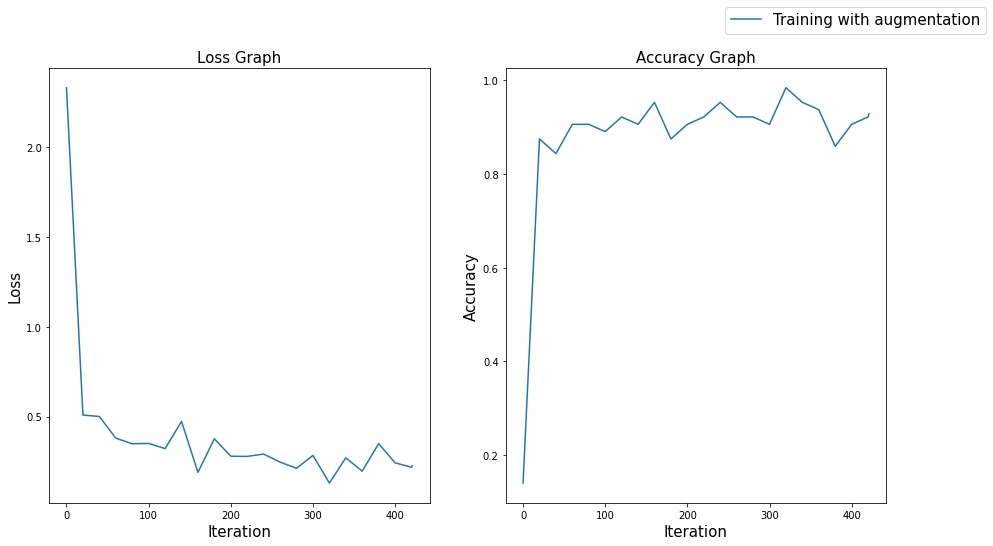

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(augmentation_train_log.iloc[:,0], label='Training with augmentation')
ax1.set_title('Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(augmentation_train_log.iloc[:,1], label='Training with augmentation')
ax2.set_title('Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()